# Mercari 

# Preprocessing of data

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,  TfidfVectorizer
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, make_scorer,mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from tabulate import tabulate
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn import utils
from sklearn import preprocessing
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import lasso_path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
def color_false_red(val):
    if val == False:
        color = 'red'
    else:
        color = 'black'
    return 'color: %s' % color

In [22]:
import warnings
warnings.simplefilter("ignore")

In [ ]:
data = pd.read_table('kaggle/mercari/train.tsv')

In [ ]:
data.shape

## Filling NA values

In [ ]:
data.brand_name.fillna(value = "NoBrand", inplace = True)
data.category_name.fillna(value = "Unknown/Unknown/Unknown", inplace = True)
data.item_description.fillna(value = "No description yet", inplace = True)

In [ ]:
data.isna().sum()

## Spliting attribute category_name on 3 columns

In [ ]:
categories = data['category_name'].str.split("/", n = 2, expand = True)

In [ ]:
data['main_category'] = categories[0]
data['1st_subcategory'] = categories[1]
data['2nd_subcategory'] = categories[2]

In [ ]:
data.drop(['category_name'], axis=1, inplace=True)

## Determing brand name from the name of the product

In [ ]:
data['brand_name'] = data['brand_name'].str.upper()
data['name'] = data['name'].str.upper()

In [ ]:
brands = data['brand_name']
unique_brands = brands.unique()

In [ ]:
unique_brands = unique_brands[unique_brands != 'BLUE']
unique_brands = unique_brands[unique_brands != 'PINK']
unique_brands = unique_brands[unique_brands != 'AND']
unique_brands = unique_brands[unique_brands != 'PRO']

In [ ]:
unique_brands.size
unique_brands_1 = []
unique_brands_more_1 = []
for i in unique_brands:
    if len(i.split()) == 1:
        unique_brands_1.append(i)
    else:
        unique_brands_more_1.append(i)
len(unique_brands_1) + len(unique_brands_more_1)

In [ ]:
t0=datetime.now()
for j in data.index:
    print(j)
    skip = False;
    if data['brand_name'][j] == 'NOBRAND':
        for i1 in unique_brands_more_1:
            if i1 in data['name'][j]:
                data.loc[[j],['brand_name']] = i1;
                skip = True;
                break;
        if skip == False:
            for i2 in unique_brands_1:
                if i2 in data['name'][j].split():
                    data.loc[[j],['brand_name']] = i2;
                    break;
t1=datetime.now()
dt = t1-t0
dt

In [ ]:
data.to_csv('brend.csv')

## Determing new variables based on the product's decsription

In [ ]:
vect = CountVectorizer(ngram_range=(1,2), min_df=30000).fit(data['item_description'])
vect.vocabulary_

In [ ]:
new = pd.DataFrame(vect.transform(data['item_description']).todense(), columns=vect.get_feature_names())
new_sum = new.sum()
for i in range(new_sum.size):
    print(new_sum.index[i], new_sum[i])

In [ ]:
selected_new = new[['authentic', 'brand new', 'bundle', 'cute', 'free shipping', 'great condition', 'good condition', 'new', 'top', 'used', 'available','beautiful', 'comes with', 'excellent condition', 'fit', 'fits', 'gold','high', 'included', 'includes','never used', 'never worn', 'original','perfect', 'worn once', 'worn']]

In [ ]:
worn_index = selected_new[(selected_new['worn'] == 1) & ((selected_new['never worn'] == 1) | (selected_new['worn once'] == 1))].index
selected_new.loc[worn_index, ['worn']].replace({1: 0}, inplace=True)
used_index = selected_new[(selected_new['used'] == 1) & (selected_new['never used'] == 1)].index
selected_new.loc[used_index, ['used']].replace({1: 0}, inplace=True)

In [ ]:
data = pd.concat([data,selected_new], axis=1)

## Filling unknown values in variables such as main, subcategory 1 and 2

In [ ]:
no_category_brand = data[(data['main_category'] == 'Unknown') & (data['brand_name'] != 'NOBRAND')]
brands_no_category = no_category_brand['brand_name'].unique()
data_brands = data[data['brand_name'].isin(brands_no_category)]
data_crosstab = pd.crosstab(data_brands['brand_name'],
data['main_category'],
margins = False)
data_crosstab.head(100)

In [ ]:
brand_category = data_crosstab.apply(lambda x: data_crosstab.columns[np.argmax(x)], axis =1)
brand_category

In [ ]:
for i in no_category_brand.index:
    data['main_category'][i] = brand_category[data['brand_name'][i]]

In [ ]:
unknown_1st_sub = data[(data['1st_subcategory'] == 'Unknown') & (data['main_category'] != 'Unknown')]
no_subcategory_category = unknown_1st_sub['main_category'].unique()

In [ ]:
no_subcategory_category

In [ ]:
data_category = data[data['main_category'].isin(no_subcategory_category)]
data_crosstab_cat = pd.crosstab(data_category['main_category'],
data_category['1st_subcategory'],
margins = False)
data_crosstab_cat.head(100)

In [ ]:
category_subcategory = data_crosstab_cat.apply(lambda x: data_crosstab_cat.columns[np.argmax(x)], axis =1)
category_subcategory

In [ ]:
for i in unknown_1st_sub.index:
    data['1st_subcategory'][i] = category_subcategory[data['main_category'][i]]

In [ ]:
unknown_2nd_sub = data[(data['1st_subcategory'] != 'Unknown') & (data['2nd_subcategory'] == 'Unknown')]
unknown_2nd_sub.shape

In [ ]:
no_2nd_1st = unknown_2nd_sub['1st_subcategory'].unique()
no_2nd_1st

In [ ]:
data_1st = data[data['1st_subcategory'].isin(no_2nd_1st)]
data_1st

In [ ]:
data_crosstab_1st = pd.crosstab(data_1st['1st_subcategory'],
data_1st['2nd_subcategory'],
margins = False)
data_crosstab_1st

In [ ]:
Fst_2nd = data_crosstab_1st.apply(lambda x: data_crosstab_1st.columns[np.argmax(x)], axis =1)
Fst_2nd

In [ ]:
for i in unknown_2nd_sub.index:
    data['2nd_subcategory'][i] = Fst_2nd[data['1st_subcategory'][i]]

## Solving problem of non unique name of the product

In [ ]:
data['name'].nunique(), data.shape, data['name'].count()

In [ ]:
data['dummy_varibale'] = data[['name', 'brand_name']].agg('---'.join, axis=1)
data['dummy_varibale'].nunique()

In [ ]:
data.drop_duplicates(subset = 'dummy_varibale', keep = 'first', inplace = True)
#Stavljamo da nam index bude promenljiva dummy_variable koja je jedinstvena za svaki artikal

In [ ]:
data.drop(['item_description'], axis=1, inplace=True)
data.drop(['name'], axis=1, inplace=True)
data.drop(['dummy_varibale'], axis=1, inplace=True)

## Dropping observations with price equal 0

In [ ]:
data = data[(data['price'] != 0)]

## Log of the product's price because of Normal Distribution

In [ ]:
data['price'] = np.log(data['price'])

## To_csv data

In [ ]:
data.to_csv('prepared.csv')

In [ ]:
data.shape

# Creating the predictive model

## Read_csv

In [5]:
data = pd.read_csv('C:/Users/Zbook G3/Desktop/posleIndex.csv')

In [6]:
data.shape

(1178663, 34)

In [7]:
data.drop(['dummy_varibale'], axis=1, inplace=True)

In [41]:
data.head()

,item_condition_id,brand_name,price,shipping,main_category,1st_subcategory,2nd_subcategory,authentic,brand new,bundle,...,gold,high,included,includes,never used,never worn,original,perfect,worn once,worn
0,3,MLB,2.302585,1,Men,Tops,T-shirts,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,RAZER,3.951244,0,Electronics,Computers & Tablets,Components & Parts,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,TARGET,2.302585,1,Women,Tops & Blouses,Blouse,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,NOBRAND,3.555348,1,Home,Home Décor,Home Décor Accents,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,1,NOBRAND,3.784190,0,Women,Jewelry,Necklaces,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Defining functions, methods and transformations of categorical columns

In [8]:
encoder = TargetEncoder(verbose=0, cols=None, drop_invariant=False, return_df=True, handle_missing='value', handle_unknown='value', min_samples_leaf=1, smoothing=1.0)

In [9]:
def model_r2(model, X, y):
    folds = KFold(n_splits=5)
    results = []
    results_train = []
    for train_index, test_index in folds.split(X):
        X_train, y_train  = X.loc[train_index, :], y[train_index]
        X_test, y_test = X.loc[test_index],  y[test_index]
        enc_model = encoder.fit(X_train, y_train)
        X_train = enc_model.transform(X_train)
        X_test = enc_model.transform(X_test)
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        y_train_hat = model.predict(X_train)
        results.append(r2_score(y_test, y_hat))
        results_train.append(r2_score(y_train, y_train_hat))
    print(f'{model}')
    print(np.mean(results))
    print(f'Train result:')
    print(np.mean(results_train))
    print('-----------------------')

In [ ]:
# U ovoj funkciji je izvresena transformacija kategorickih promenljivih u numericke pomocu TargetEncoder-a.
# Kako bi se sprecilo curenje informacija, prvo je podaci podeljeni na train i test deo, a zatim se 
# encoder model kreirao samo nad train podacima

In [10]:
def rmse_score(y_true, y_predict):
    diff = y_true-y_predict
    diff_squared = np.power(diff,2)
    mse = diff_squared.mean()
    rmse = np.sqrt(mse)
    return(rmse)

def error_stats(cv_dict):
    stats = {}
    for k,v in cv_dict.items(): 
        stats.update({k:(v.mean(), v.std())})
    return(stats)

rmse = make_scorer(rmse_score, greater_is_better=False)

def stats(y_true, y_predict):
    MAE = mean_absolute_error(y_true,y_predict)
    MSE = mean_squared_error(y_true, y_predict)
    RMSE = np.sqrt(mean_squared_error(y_true, y_predict))
    R2 = r2_score(y_true, y_predict)
    
    print('MAE:', MAE)
    print('MSE:', MSE)
    print('RMSE:', RMSE)
    print('R2:', R2)
    
    return {'MAE' : MAE, 'MSE' : MSE, 'RMSE' : RMSE, 'R2':R2}

## Splitting data on X and y

In [11]:
X = data.drop(['price'], axis=1, inplace=False)
y = data.iloc[:,2]

In [12]:
X = pd.DataFrame(X)

In [46]:
type(y)

pandas.core.series.Series

In [49]:
y

0          2.302585
1          3.951244
2          2.302585
3          3.555348
4          3.784190
             ...   
1178658    3.526361
1178659    2.995732
1178660    2.639057
1178661    3.806662
1178662    3.091042
Name: price, Length: 1178663, dtype: float64

# Optimization of hyperparameters relative to R^2 statistics

In [15]:
model_r2(Ridge(normalize= True), X, y)
# Ridge 0.34 -> 0.41

Ridge(normalize=True)
0.3448610720411742
Train result:
0.3471447391467123
-----------------------


In [21]:
model_r2(Lasso(normalize= True), X, y)
# Lasso 0

Lasso(normalize=True)
-1.1519642854818102e-05
Train result:
0.0
-----------------------


In [20]:
model_r2(DecisionTreeRegressor(), X, y)
# DecisionTreRegressor -> 0.28

DecisionTreeRegressor()
0.2837782739139388
Train result:
0.7657885469586473
-----------------------


In [14]:
model_r2(LinearRegression(), X, y)
# LinearRegression 0.41 -> 0.41

LinearRegression()
0.4101605780430999
Train result:
0.41400088953695596
-----------------------


In [16]:
model_r2(AdaBoostRegressor(), X, y)
# AdaBoostRegressor 0.09 -> 0.34
#                   0.16 -> 0.34

AdaBoostRegressor()
0.16318459240219807
Train result:
0.1666228402241627
-----------------------


In [17]:
model_r2(GradientBoostingRegressor(), X, y)
# GradientBoostingRegressor 0.43

GradientBoostingRegressor()
0.4319008192883408
Train result:
0.43583549837288604
-----------------------


In [18]:
model_r2(BaggingRegressor(), X, y)
# Bagging 0.438 -> 0.486

BaggingRegressor()
0.4385832511290883
Train result:
0.7199465063347381
-----------------------


In [19]:
model_r2(RandomForestRegressor(), X, y)
# RandomForestRegressor 0.45 -> 0.56

RandomForestRegressor()
0.4578045352448843
Train result:
0.7335868121684548
-----------------------


In [ ]:
# Stacking

### Optimization of parameter alpha for Ridge

In [50]:
for i in [0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9, 1]:
    print(i)
    model_r2(Ridge(normalize= True, alpha = i), X, y)
    print('------------------')

0.01
Ridge(alpha=0.01, normalize=True)
0.41015392933298706
Train result:
0.4139623008092402
-----------------------
------------------
0.03
Ridge(alpha=0.03, normalize=True)
0.4099347107052308
Train result:
0.41368164109450606
-----------------------
------------------
0.05
Ridge(alpha=0.05, normalize=True)
0.4094916029832592
Train result:
0.4131800573064595
-----------------------
------------------
0.07
Ridge(alpha=0.07, normalize=True)
0.4088704248013423
Train result:
0.412503078098
-----------------------
------------------
0.09
Ridge(alpha=0.09, normalize=True)
0.40810510843977205
Train result:
0.4116843933388745
-----------------------
------------------
0.1
Ridge(alpha=0.1, normalize=True)
0.4076767105732609
Train result:
0.41123015790724204
-----------------------
------------------
0.3
Ridge(alpha=0.3, normalize=True)
0.3955718551626907
Train result:
0.398698430178703
-----------------------
------------------
0.5
Ridge(alpha=0.5, normalize=True)
0.3809486310845287
Train resul

In [21]:
#Najbolja vrednost je 0.01 za alfa 

In [ ]:
for i in np.linspace(start=0, stop=1, num=101):
    print(i)
    model_r2(Ridge(normalize= True, alpha = i), X, y)
    print('------------------')

In [22]:
#Najbolja vrednost za alfa je 0.07

### Optmiziation of parameters for AdaBoost

In [193]:
for i1 in [20, 30, 50, 70, 100, 150, 200]:
    for i2 in [0.01, 0.05, 0.075, 0.1, 0.3, 0.5, 0.7, 1]:
        print(f'N of estimators: {i1}')
        print(f'Learning rate: {i2}')
        model_r2(AdaBoostRegressor(n_estimators=i1, learning_rate=i2), X, y)

In [ ]:
for i in [0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1]:
    print(f'Learning rate: {i}')
    model_r2(AdaBoostRegressor(base_estimator=Ridge(alpha=0.01), n_estimators=10, learning_rate=i), X, y)

In [ ]:
# N_estimators = 30 L rate = 0.1

In [ ]:
 model_r2(AdaBoostRegressor(n_estimators=30, learning_rate=0.1), X, y)

In [ ]:
# max_depth=6, n_estimators=200, learning_rate=0.8

### Optmiziation of parameters for GradientBoostingRegressor

In [ ]:
lr = [0.7, 0.8, 0.9, 1, 1.1, 1.2]
est = [100, 200, 150]
for i1 in est:
    for i2 in lr:
        print(f'Estimators: {i1} learning rate: {i2}')
        model_r2(GradientBoostingRegressor(n_estimators=i1, learning_rate=i2), X, y)

In [ ]:
for i1 in [5, 7, 10, 15]:
    print(f'Depth: {i1}')
    model_r2(GradientBoostingRegressor(max_depth=i1, n_estimators=100, learning_rate=0.8), X, y)

In [ ]:
for i1 in [4,6]:
    print(f'Depth: {i1}')
    model_r2(GradientBoostingRegressor(max_depth=i1, n_estimators=100, learning_rate=0.8), X, y)

In [ ]:
 model_r2(GradientBoostingRegressor(n_estimators=30, learning_rate=1.5), X, y)

### Optmiziation of parameters for Bagging

In [ ]:
for i1 in [10, 20, 30, 50, 70, 100, 150, 200]:
    for i2 in [0.1, 0.3, 0.5, 0.7, 1]:
        for i3 in [0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 1]:
            print(f'N of estimators: {i1}')
            print(f'Max samples: {i2}')
            print(f'Max features: {i3}')
            model_r2(BaggingRegressor(n_estimators=i1, max_features=i2, max_samples=i3, n_jobs=2), X, y)

In [ ]:
#Najbolja vrednost se dobija za parametre n_estimators = 70, max_features = 0.7, max_samples = 0.5

### Optmiziation of parameters for Random forest

In [ ]:
est = [100, 200]
dep = [30, 35, 45]
min_sam = [5,6, 7]
for i1 in est:
    for i2 in dep:
        for i3 in min_sam:
            print(f'Estimators: {i1} Depth: {i2} Min samlpes: {i3}')
            model_r2(RandomForestRegressor(n_estimators=i1, max_depth=i2, min_samples_leaf=i3, n_jobs=-1), X, y)

In [ ]:
est = [30, 50, 70, 25, 20]
dep = [17, 23, 15, 25, 15, 27, 19, 21]
for i1 in est:
    for i2 in dep:
        print(f'Estimators: {i1} Depth: {i2} Min samlpes: {i3}')
        model_r2(StackingRegressor(estimators = [('LR', Ridge(normalize= True, alpha = 0.01)), ('BAG', BaggingRegressor(n_estimators=70, max_features=0.7, max_samples=0.5, n_jobs=-1)) ,('RF', RandomForestRegressor(max_depth=i2, min_samples_leaf=5, n_estimators=i1, n_jobs=-1))], final_estimator=LinearRegression(), cv=None, n_jobs=-1), X, y)

In [ ]:
#Za 500.000 najbolji parametri su da je depth 20, a min samples 6. Zanemarljivo je poboljasnje za povecanje n estimators.
#Iz tog razloga uzima se 30 za n estimators

In [ ]:
#Min samples je 6

In [ ]:
model_r2(RandomForestRegressor(max_depth=20, min_samples_leaf=6, n_estimators=30,n_jobs=-1), X, y)

In [ ]:
est = [17, 19, 21, 23, 25, 32, 40, 50, 60]
dep = [7, 9, 11, 13, 15]
min_sam = [3, 5, 7]
for i1 in est:
    for i2 in dep:
        for i3 in min_sam:
            print(f'Estimators: {i1} Depth: {i2} Min samlpes: {i3}')
            model_r2(RandomForestRegressor(n_estimators=i1, max_depth=i2, min_samples_leaf=i3), X, y)

In [ ]:
#Najbolja vrednost se dobija za n_estimators = 40, max_depth = 10, min_samples_leaf = 5

In [ ]:
verb = [1, 3, 5, 7]
min_sam_spl = [2, 5,10,15, 20, 25, 40]
for i1 in verb:
    for i3 in min_sam_spl:
            print(f'Verbose: {i1} Weight: {0} Min samlpes split: {i3}')
            model_r2(RandomForestRegressor(n_estimators=20, max_depth=20, min_samples_leaf=6, verbose=i1,
                                           min_weight_fraction_leaf=0, min_samples_split=i3, n_jobs=-1), X, y)

In [ ]:
min_sam_spl = [50, 75, 100, 150, 200]
for i1 in verb:
    for i3 in min_sam_spl:
            print(f'Verbose: {0} Weight: {0} Min samlpes split: {i3}')
            model_r2(RandomForestRegressor(n_estimators=20, max_depth=20, min_samples_leaf=6, verbose=0,
                                           min_weight_fraction_leaf=0, min_samples_split=i3, n_jobs=-1), X, y)

In [ ]:
#Otkriveno je da RandomForest ima mnogo veci potencijal u smislu vrednosti r2 ukoliko se parametar warm_start podesi na
#True. Iz tog razloga se radi ponovna optimizacija parametara kako bi se vrednost r2 maksimizirala

In [ ]:
for depth in [50, 60, 70, 100]:
    model_r2(RandomForestRegressor(n_estimators=20, max_depth=depth, min_samples_leaf=2,
                                       warm_start=True, n_jobs=-1), X, y)

In [ ]:
for min_sam in [2, 1]:
    for est in [30, 50, 75, 100, 200]:
        for depth in [70, 80, 90, 100]:
            model_r2(RandomForestRegressor(n_estimators=est, max_depth=depth, min_samples_leaf=min_sam,
                                               warm_start=True, n_jobs=-1), X, y)

In [ ]:
#Optimizovani RandomForest sa 0.55 vrednosti za r2:
#RandomForestRegressor(max_depth=33, n_estimators=200, n_jobs=-1, min_samples_leaf=1, warm_start=True)

### Stacking

In [ ]:
est = [0.01, 0.03, 0.05, 0.075, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
for i in est:
    print(f'Alfa final estimator: {i}')
    model_r2(StackingRegressor(estimators = [('LR', Ridge(normalize= True, alpha = 0.01)), ('BAG', BaggingRegressor(n_estimators=70, max_features=0.7, max_samples=0.5, n_jobs=-1)) ,('RF', RandomForestRegressor(max_depth=20, min_samples_leaf=6, n_estimators=30, n_jobs=-1))], final_estimator=Ridge(alpha=i), cv=None, n_jobs=-1), X, y)

In [ ]:
t0=datetime.now()
model_stacking = StackingRegressor(estimators = [('LR', Ridge(normalize= True, alpha = 0.01)), ('ADA', AdaBoostRegressor(n_estimators=30, learning_rate=0.1)), ('BAG', BaggingRegressor(n_estimators=70, max_features=0.7, max_samples=0.5, n_jobs=-1)) ,('RF', RandomForestRegressor(max_depth=30, min_samples_leaf=6, n_estimators=100, n_jobs=-1))], final_estimator=LinearRegression(), cv=None, n_jobs=-1)
folds = KFold(n_splits=2)
results = []
results_train = []
for train_index, test_index in folds.split(X):
    X_train, y_train  = X.loc[train_index, :], y[train_index]
    X_test, y_test = X.loc[test_index],  y[test_index]
    enc_model = encoder.fit(X_train, y_train)
    X_train = enc_model.transform(X_train)
    X_test = enc_model.transform(X_test)
    model_stacking.fit(X_train, y_train)
    y_hat = model_stacking.predict(X_test)
    y_train_hat = model_stacking.predict(X_train)
    results_train.append(r2_score(y_train, y_train_hat))
    results.append(r2_score(y_test, y_hat))
    print(r2_score(y_test, y_hat))
    print(f'{model_stacking}')
    print(np.mean(results))
    print('train results')
    print(np.mean(results_train))
t1=datetime.now()
dt = t1-t0
dt

In [ ]:
#Najbolji rezultat dobijen za alfa = 0.9

In [ ]:
model_r2(StackingRegressor(estimators = [('LR', Ridge(normalize= True, alpha = 0.01)), ('BOO', GradientBoostingRegressor(max_depth=6, n_estimators=100, learning_rate=0.8)), ('BAG', BaggingRegressor(n_estimators=100, max_features=0.85, max_samples=0.5, n_jobs=-1)) ,('RF', RandomForestRegressor(max_depth=20, min_samples_leaf=6, n_estimators=100, n_jobs=-1))], final_estimator=Ridge(alpha=0.9), cv=None, n_jobs=-1), X, y)

In [ ]:
t0=datetime.now()
model_r2(StackingRegressor(estimators = [('LR', Ridge(normalize= True, alpha = 0.01)), ('BOO', GradientBoostingRegressor(max_depth=6, n_estimators=200, learning_rate=0.8)), ('BAG', BaggingRegressor(n_estimators=200, max_features=0.85, max_samples=0.5, n_jobs=-1)) ,('RF', RandomForestRegressor(max_depth=20, min_samples_leaf=6, n_estimators=200, n_jobs=-1))], final_estimator=Ridge(alpha=0.9), cv=None, n_jobs=-1), X, y)
t1=datetime.now()
dt = t1-t0
dt

In [ ]:
#Bolje vrednosti se dobijaju za n_estimators>15, max_depth>5, min_samples_leaf>1. Ponavlja se pretraga sa
#prilagodjenim vrednostima

### Creating model for prediction based on Stacking

#### Determing weak algorithms for Stacking

In [ ]:
XDvesta = X.head(200000)
yDvesta = y.head(200000)

In [54]:
models = []
models.append(Ridge())
models.append(RandomForestRegressor())
models.append(AdaBoostRegressor())
models.append(BaggingRegressor())

In [ ]:
for model in models:
    model_stacking = StackingRegressor(estimators = [('LR', Ridge(normalize= True, alpha = 0.07)), ('ADA', AdaBoostRegressor(n_estimators=30, learning_rate=0.1)), ('BAG', BaggingRegressor(n_estimators=30, max_samples=0.65, max_features=0.5)) ,('RF', x())], final_estimator=model, cv=None)
    results = []
    folds = KFold(n_splits=10)
    for train_index, test_index in folds.split(X):
        X_train, y_train  = X.loc[train_index, :], y[train_index]
        X_test, y_test = X.loc[test_index],  y[test_index]

        enc_model = encoder.fit(X_train, y_train)
        X_train = enc_model.transform(X_train)
        X_test = enc_model.transform(X_test)
        model_stacking.fit(X_train, y_train)
        y_hat = model_stacking.predict(X_test)
        results.append(r2_score(y_test, y_hat))
        print(r2_score(y_test, y_hat))
    print(f'{model}')
    print(np.mean(results))

In [ ]:
#Kao najbolji algoritam pokazao se Ridgde

In [367]:
t0=datetime.now()

model_stacking = StackingRegressor(estimators = [('LR', Ridge(normalize= True, alpha = 0.01)), ('ADA', GradientBoostingRegressor(max_depth= 6,n_estimators=200, learning_rate=0.8)), ('BAG', BaggingRegressor(n_estimators = 200, max_features = 0.85, max_samples = 0.5)) ,('RF', RandomForestRegressor(n_estimators = 100, max_depth = 50, min_samples_leaf = 2, warm_start=True))], final_estimator=Ridge(alpha=0.9), cv=None)
model_r2(model_stacking, X, y)
# Random forest su : n_estimators = 100, max_depth = 50, min_samples_leaf = 2, warm_start=True

t1=datetime.now()
dt = t1-t0
dt

StackingRegressor(estimators=[('LR', Ridge(alpha=0.01, normalize=True)),
                              ('ADA',
                               GradientBoostingRegressor(learning_rate=0.8,
                                                         max_depth=6,
                                                         n_estimators=200)),
                              ('BAG',
                               BaggingRegressor(max_features=0.85,
                                                max_samples=0.5,
                                                n_estimators=200)),
                              ('RF',
                               RandomForestRegressor(max_depth=50,
                                                     min_samples_leaf=2,
                                                     warm_start=True))],
                  final_estimator=Ridge(alpha=0.9))
0.5105512400725651
Train result:
0.628848270238864
-----------------------


datetime.timedelta(seconds=45653, microseconds=619057)

In [ ]:
t0=datetime.now()

model_stacking = StackingRegressor(estimators = [('LR', Ridge(normalize= True, alpha = 0.01)), ('ADA', GradientBoostingRegressor(max_depth= 6,n_estimators=200, learning_rate=0.8)), ('BAG', BaggingRegressor(n_estimators = 200, max_features = 0.85, max_samples = 0.5)) ,('RF', RandomForestRegressor(n_estimators=200, max_depth=33, min_samples_leaf=1,
warm_start=True, n_jobs=-1))], final_estimator=Ridge(alpha=0.9), cv=None, n_jobs=-1)
model_r2(model_stacking, X, y)
# Random forest su : n_estimators=200, max_depth=33, min_samples_leaf=1, warm_start=True

t1=datetime.now()
dt = t1-t0
dt

In [369]:
model_r2(StackingRegressor(estimators = [('LR', Ridge(normalize= True, alpha = 0.01)), ('BOO', GradientBoostingRegressor(max_depth=6, n_estimators=200, learning_rate=0.8)), ('BAG', BaggingRegressor(n_estimators=200, max_features=0.85, max_samples=0.5)) ,('RF', RandomForestRegressor(max_depth=20, min_samples_leaf=6, n_estimators=200))], final_estimator=Ridge(alpha=0.9), cv=None), X, y)
# optimizovatiii

In [370]:
XNov = X.head(100000)
yNov = y.head(100000)

In [372]:
model = RandomForestRegressor(n_estimators=200, max_depth=33, min_samples_leaf=1, warm_start=True, n_jobs=-1)
model_r2(model, XNov, yNov)

RandomForestRegressor(max_depth=33, n_estimators=200, n_jobs=-1,
                      warm_start=True)
0.5406658474842776
Train result:
0.6077389025908279
-----------------------


In [373]:
# za sada najbolja metrika - 0.54

## Attribute selection

### Filter metode - VarianceThreshold

In [374]:
selection = VarianceThreshold(0.05)
selection.fit(X_train)

print(selection.get_support())
print('--------------------')
print(selection.get_support().sum())

[ True  True  True False  True  True False  True  True  True  True False
 False  True  True  True False False False False  True False  True False
 False False False False False  True False  True]
--------------------
16


In [375]:
lista = selection.get_support()
lista[3] = True
lista # Sacuvali smo main_category varijablu, jer smatramo daje svakako bitna

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False, False,  True,  True,  True, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False,  True, False,  True])

In [376]:
dfVariance = pd.DataFrame({'Ime kolone' : X.columns.tolist(),
                   'Vrednost T/F' : lista.tolist()})

In [377]:
dfVariance.style.applymap(color_false_red)

,Ime kolone,Vrednost T/F
0,item_condition_id,True
1,brand_name,True
2,shipping,True
3,main_category,True
4,1st_subcategory,True
5,2nd_subcategory,True
6,authentic,False
7,brand new,True
8,bundle,True
9,cute,True


In [378]:
X_reduced_VarianceTreshold = XNov.loc[:, lista]

In [ ]:
model = StackingRegressor(estimators = [('LR', Ridge(normalize= True, alpha = 0.07)), ('ADA', AdaBoostRegressor(n_estimators=30, learning_rate=0.1)), ('BAG', BaggingRegressor(n_estimators=30, max_samples=0.65, max_features=0.5)) ,('RF', RandomForestRegressor())], final_estimator=Ridge(), cv=None)

model_r2(model, X_reduced_VarianceTreshold, yNov)

In [ ]:
# Na train delu su rezultati bili dobri, ali na testu su za 2% gori od StackingRegressor sa svim atributima

In [380]:
model = RandomForestRegressor(n_estimators=200, max_depth=33, min_samples_leaf=1, warm_start=True, n_jobs=-1)

model_r2(model, X_reduced_VarianceTreshold, yNov)

RandomForestRegressor(max_depth=33, n_estimators=200, n_jobs=-1,
                      warm_start=True)
0.49515109179258604
Train result:
0.5651512543162589
-----------------------


In [382]:
# Nise su se poboljsali rezultati ni za RandomForestRegressor

### Wrapper methods

In [399]:
X_trainNov, X_testNov, y_trainNov, y_testNov = train_test_split(X, y)
enc_model = encoder.fit(X_trainNov, y_trainNov)
X_trainNov = enc_model.transform(X_trainNov)
X_testNov = enc_model.transform(X_testNov)
lab_enc = preprocessing.LabelEncoder()
training_scores_y_encoded = lab_enc.fit_transform(y_trainNov)

In [400]:
X_trainNov3 = X_trainNov.head(20000)
training_scores_y_encoded3 = training_scores_y_encoded[0:20000]

In [402]:
model = RandomForestRegressor(n_estimators=200, max_depth=33, min_samples_leaf=1, warm_start=True, n_jobs=-1)

model_as = RFECV(estimator=model, 
                 min_features_to_select=10, cv=5, step=1, 
                 scoring='r2')

model_as.fit(X_trainNov3, training_scores_y_encoded3)

listObavijanje = model_as.get_support()

In [403]:
yDvadeset = y.head(20000)
XDvadeset = X.head(20000)
XDvadeset.shape, yDvadeset.shape

((20000, 32), (20000,))

In [404]:
X_reduced_Obavijanje = XDvadeset.loc[:, listObavijanje]

model_r2(model, X_reduced_Obavijanje, yDvadeset)

RandomForestRegressor(max_depth=33, n_estimators=200, n_jobs=-1,
                      warm_start=True)
0.5062326178085684
Train result:
0.6238240508857311
-----------------------


In [405]:
# nisu bolji rezultati

### Embedded methods

In [251]:
X_trainNov, X_testNov, y_trainNov, y_testNov = train_test_split(X, y)
enc_model = encoder.fit(X_trainNov, y_trainNov)
X_trainNov = enc_model.transform(X_trainNov)
X_testNov = enc_model.transform(X_testNov)
lab_enc = preprocessing.LabelEncoder()
training_scores_y_encoded = lab_enc.fit_transform(y_trainNov)

In [252]:
X_trainNov4 = X_trainNov.head(100000)
training_scores_y_encoded4 = training_scores_y_encoded[0:100000]

In [255]:
model = LinearRegression()

sfm = SelectFromModel(model, threshold=0.01)
sfm.fit(X_trainNov4, training_scores_y_encoded4)
print(sum(sfm.get_support()))
X.columns[sfm.get_support()]

32


Index(['item_condition_id', 'brand_name', 'shipping', 'main_category',
       '1st_subcategory', '2nd_subcategory', 'authentic', 'brand new',
       'bundle', 'cute', 'free shipping', 'great condition', 'good condition',
       'new', 'top', 'used', 'available', 'beautiful', 'comes with',
       'excellent condition', 'fit', 'fits', 'gold', 'high', 'included',
       'includes', 'never used', 'never worn', 'original', 'perfect',
       'worn once', 'worn'],
      dtype='object')

(-1.4174814635334996,
 1.1136515316968798,
 -4.363970117272768,
 15.533856217369205)

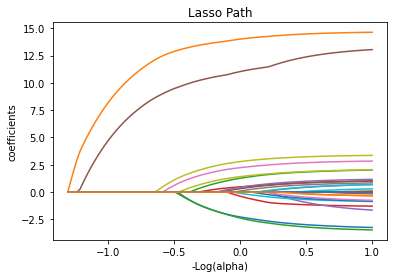

In [261]:
alphas, coefs, _ = lasso_path(StandardScaler().fit_transform(X_trainNov4), training_scores_y_encoded4, 5e-3, fit_intercept=False)

plt.figure(1)
neg_log_alphas_lasso = -np.log10(alphas)
for coef in (coefs):
    l1 = plt.plot(neg_log_alphas_lasso, coef)
plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Path')
plt.axis('tight')

<AxesSubplot:ylabel='att'>

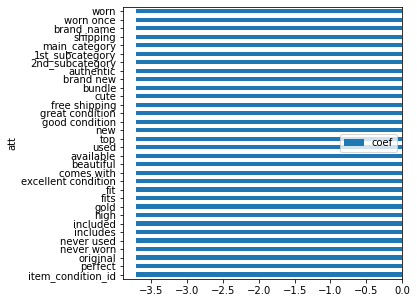

In [284]:
model = Ridge(alpha=0.01)

model.fit(X_trainNov, training_scores_y_encoded)

coefs = pd.DataFrame({'att':X_trainNov.columns, 'coef':model.coef_[0]}).sort_values(by='coef',ascending=True)
coefs.plot.barh(x='att',y='coef',figsize=(5, 5))
# pusti opet

In [281]:
model.coef_

array([-3.70938049, 35.59171472, -7.34252528, -9.77342397, -6.1128559 ,
       34.76970863, 13.96209085,  0.24623778, -0.50213137, -4.27270032,
       -3.61586163,  1.4525631 , -1.01533646,  1.85100751,  3.75114512,
        0.67253037, -0.23706047,  5.9140284 , 18.96325336,  4.01815022,
        0.3401568 , -2.03533322,  7.90718209, -0.3899397 ,  8.09143455,
        7.56628796, -5.79999607, -0.72308259, 11.1237032 ,  1.69941399,
        0.95461619, -0.90414506])

## Construction of polynomial attributes and selection (K best)

In [ ]:
folds = KFold(n_splits=5)
for train_index, test_index in folds.split(X):
    X_train, y_train  = X.loc[train_index, :], y[train_index]
    X_test, y_test = X.loc[test_index],  y[test_index]
    enc_model = encoder.fit(X_, y_train)
    X_train = enc_model.transform(X_train)
    X_test = enc_model.transform(X_test)
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    y_train_hat = model.predict(X_train)
    results.append(r2_score(y_test, y_hat))
    results_train.append(r2_score(y_train, y_train_hat))
print(f'{model}')
print(np.mean(results))
print(f'Train result:')
print(np.mean(results_train))
print('-----------------------')

In [ ]:
enc_model = encoder.fit(X, y)

In [ ]:
X_enc = enc_model.transform(X)

In [ ]:
model_poly = PolynomialFeatures(degree=2).fit(X_enc)

In [ ]:
X_new = model_poly.transform(X_enc)

In [ ]:
X_new_data = pd.DataFrame(X_new)

### 32 attributes

In [ ]:
selection = SelectKBest(f_regression, k = 32)

In [ ]:
selection.fit(X_new_data, y)

In [ ]:
selection.get_support()

In [ ]:
X_filter = X_new_data.loc[:, selection.get_support()]

In [ ]:
folds = KFold(n_splits=5)
results = []
results_train = []
model = RandomForestRegressor(n_estimators=200, max_depth=33, min_samples_leaf=1,warm_start=True, n_jobs=-1)
for train_index, test_index in folds.split(X_filter):
    X_train, y_train  = X_filter.loc[train_index, :], y[train_index]
    X_test, y_test = X_filter.loc[test_index],  y[test_index]
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    y_train_hat = model.predict(X_train)
    results.append(r2_score(y_test, y_hat))
    results_train.append(r2_score(y_train, y_train_hat))
print(f'{model}')
print(np.mean(results))
print(f'Train result:')
print(np.mean(results_train))
print('-----------------------')

In [ ]:
#ovo je rezultat sa 32 atributa -> 0.57108

### 25 attributes

In [ ]:
selection = SelectKBest(f_regression, k = 25)
selection.fit(X_filter, y)
X_filter = X_filter.loc[:, selection.get_support()]

In [ ]:
folds = KFold(n_splits=5)
results = []
results_train = []
model = RandomForestRegressor(n_estimators=200, max_depth=33, min_samples_leaf=1,warm_start=True, n_jobs=-1)
for train_index, test_index in folds.split(X_filter):
    X_train, y_train  = X_filter.loc[train_index, :], y[train_index]
    X_test, y_test = X_filter.loc[test_index],  y[test_index]
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    y_train_hat = model.predict(X_train)
    results.append(r2_score(y_test, y_hat))
    results_train.append(r2_score(y_train, y_train_hat))
print(f'{model}')
print(np.mean(results))
print(f'Train result:')
print(np.mean(results_train))
print('-----------------------')

In [ ]:
#rezultat sa 25 atributa -> 0.5195

### 50 attributes

In [ ]:
selection = SelectKBest(f_regression, k = 50)
selection.fit(X_new_data, y)
X_filter = X_new_data.loc[:, selection.get_support()]

In [ ]:
folds = KFold(n_splits=5)
results = []
results_train = []
model = RandomForestRegressor(n_estimators=200, max_depth=33, min_samples_leaf=1,warm_start=True, n_jobs=-1)
for train_index, test_index in folds.split(X_filter):
    X_train, y_train  = X_filter.loc[train_index, :], y[train_index]
    X_test, y_test = X_filter.loc[test_index],  y[test_index]
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    y_train_hat = model.predict(X_train)
    results.append(r2_score(y_test, y_hat))
    results_train.append(r2_score(y_train, y_train_hat))
print(f'{model}')
print(np.mean(results))
print(f'Train result:')
print(np.mean(results_train))
print('-----------------------')

In [ ]:
#rezultat sa 50 atributa -> 0.5823

### 45 attributes

In [ ]:
selection = SelectKBest(f_regression, k = 45)
selection.fit(X_filter, y)
X_filter = X_filter.loc[:, selection.get_support()]

In [ ]:
folds = KFold(n_splits=5)
results = []
results_train = []
model = RandomForestRegressor(n_estimators=200, max_depth=33, min_samples_leaf=1,warm_start=True, n_jobs=-1)
for train_index, test_index in folds.split(X_filter):
    X_train, y_train  = X_filter.loc[train_index, :], y[train_index]
    X_test, y_test = X_filter.loc[test_index],  y[test_index]
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    y_train_hat = model.predict(X_train)
    results.append(r2_score(y_test, y_hat))
    results_train.append(r2_score(y_train, y_train_hat))
print(f'{model}')
print(np.mean(results))
print(f'Train result:')
print(np.mean(results_train))
print('-----------------------')

In [ ]:
#rezultat za 45 atributa -> 0.5764

### 70 attributes

In [ ]:
selection = SelectKBest(f_regression, k = 70)
selection.fit(X_new_data, y)
X_filter = X_new_data.loc[:, selection.get_support()]

In [ ]:
folds = KFold(n_splits=5)
results = []
results_train = []
model = RandomForestRegressor(n_estimators=200, max_depth=33, min_samples_leaf=1,warm_start=True, n_jobs=-1)
for train_index, test_index in folds.split(X_filter):
    X_train, y_train  = X_filter.loc[train_index, :], y[train_index]
    X_test, y_test = X_filter.loc[test_index],  y[test_index]
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    y_train_hat = model.predict(X_train)
    results.append(r2_score(y_test, y_hat))
    results_train.append(r2_score(y_train, y_train_hat))
print(f'{model}')
print(np.mean(results))
print(f'Train result:')
print(np.mean(results_train))
print('-----------------------')

In [ ]:
# rezultat za 70 -> 0.61381

### 150 attributes

In [ ]:
selection = SelectKBest(f_regression, k = 150)
selection.fit(X_new_data, y)
X_filter = X_new_data.loc[:, selection.get_support()]

In [ ]:
folds = KFold(n_splits=5)
results = []
results_train = []
model = RandomForestRegressor(n_estimators=200, max_depth=33, min_samples_leaf=1,warm_start=True, n_jobs=-1)
for train_index, test_index in folds.split(X_filter):
    X_train, y_train  = X_filter.loc[train_index, :], y[train_index]
    X_test, y_test = X_filter.loc[test_index],  y[test_index]
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    y_train_hat = model.predict(X_train)
    results.append(r2_score(y_test, y_hat))
    results_train.append(r2_score(y_train, y_train_hat))
print(f'{model}')
print(np.mean(results))
print(f'Train result:')
print(np.mean(results_train))
print('-----------------------')

In [ ]:
# Rezultat za 150 -> 0.64068

### 300 attributes

In [ ]:
selection = SelectKBest(f_regression, k = 300)
selection.fit(X_new_data, y)
X_filter = X_new_data.loc[:, selection.get_support()]

In [ ]:
folds = KFold(n_splits=5)
results = []
results_train = []
model = RandomForestRegressor(n_estimators=50, max_depth=33, min_samples_leaf=1,warm_start=True, n_jobs=-1)
for train_index, test_index in folds.split(X_filter):
    X_train, y_train  = X_filter.loc[train_index, :], y[train_index]
    X_test, y_test = X_filter.loc[test_index],  y[test_index]
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    y_train_hat = model.predict(X_train)
    results.append(r2_score(y_test, y_hat))
    results_train.append(r2_score(y_train, y_train_hat))
print(f'{model}')
print(np.mean(results))
print(f'Train result:')
print(np.mean(results_train))
print('-----------------------')

In [ ]:
# Rezultat za 300 atributa -> 0.6503

### Checking R^2 adjusted statistics

In [ ]:
def r2_adj(r2, n, k):
    return (1 - ((1 - r2) * (n - 1)/(n - k - 1)))

In [ ]:
r2_adj(0.65, 250000, 300) 
# 0.6495794937104273

In [ ]:
r2_adj(0.649, 250000, 150)
# 0.6487892727207234

In [ ]:
#Cak i sa prilagodjenim r2 dobija se da je optimalni broj atributa 300.

In [ ]:
#Iznenadjujuce, ali Stacking se pokazao kao gori izbor u poredjenju sa RadnomForest-om
#Random Forest ostaje kao algoritam koji je pruzio najbolji rezultat u smislu r2, i to 0.65

### VarianceTreshold - selection od attributes

In [419]:
selection = VarianceThreshold(0.05)
selection.fit(X_new_dataSto)

print(selection.get_support())
print('--------------------')
print(selection.get_support().sum())

[False  True  True  True False  True  True False  True  True  True  True
 False False  True  True  True False False False False  True False  True
 False False False False False False  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True False  True False False  True
 False  True False False False False False False False False False False
 False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [420]:
len(selection.get_support()), X_new_dataSto.shape

(561, (100000, 561))

In [421]:
dfVarianceGenAtr = pd.DataFrame({'Ime kolone' : X_new_dataSto.columns.tolist(),
                   'Vrednost T/F' : selection.get_support().tolist()})

In [422]:
dfVarianceGenAtr.style.applymap(color_false_red)

,Ime kolone,Vrednost T/F
0,0,False
1,1,True
2,2,True
3,3,True
4,4,False
5,5,True
6,6,True
7,7,False
8,8,True
9,9,True


In [423]:
X_reduced_VarianceTreshold_GenAtr = X_new_dataSto.loc[:, selection.get_support().tolist()]

In [424]:
X_new_data_testVarGenAtr = X_new_data_test.loc[:, selection.get_support().tolist()]

In [425]:
X_reduced_VarianceTreshold_GenAtr.shape, y_trainNovSto.shape, X_new_data_testVarGenAtr.shape

((100000, 200), (100000,), (50000, 200))

In [426]:
X_reduced_VarianceTreshold_GenAtr.shape, y_trainNovSto.shape, X_new_data_testVarGenAtr.shape

((100000, 200), (100000,), (50000, 200))

In [427]:
model = RandomForestRegressor(n_estimators=200, max_depth=33, min_samples_leaf=1, warm_start=True, n_jobs=-1)

#model_r2(model, X_reduced_VarianceTreshold_GenAtr, y_trainNovSto)

modelFitVarGenAtr = model.fit(X_reduced_VarianceTreshold_GenAtr, y_trainNovSto)
modelPredictVarGenAtr = modelFitVarGenAtr.predict(X_new_data_testVarGenAtr)

In [428]:
stats(y_test.head(50000),modelPredictVarGenAtr)

MAE: 0.7624856165462872
MSE: 0.9599001625747354
RMSE: 0.9797449477158509
R2: -0.5366814713669661


{'MAE': 0.7624856165462872,
 'MSE': 0.9599001625747354,
 'RMSE': 0.9797449477158509,
 'R2': -0.5366814713669661}

In [363]:
#malo bolji rez u odnosu na 561 atribut, ali generalno losiji od naseg najboljeg